In [118]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, Input, MaxPooling2D, Activation, Flatten
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam

from keras.initializers import HeUniform

In [122]:
directorio = "archive/raw-img"
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(directorio,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)
train_data = train_datagen.flow_from_directory(directorio,
                                               target_size=(224,224),
                                               batch_size = 32,
                                               class_mode = "categorical")

test_data = test_datagen.flow_from_directory(directorio,
                                               target_size=(224,224),
                                               batch_size = 32,
                                               class_mode = "categorical")

                                               

Found 26179 images belonging to 10 classes.
Found 26179 images belonging to 10 classes.
Found 26179 images belonging to 10 classes.


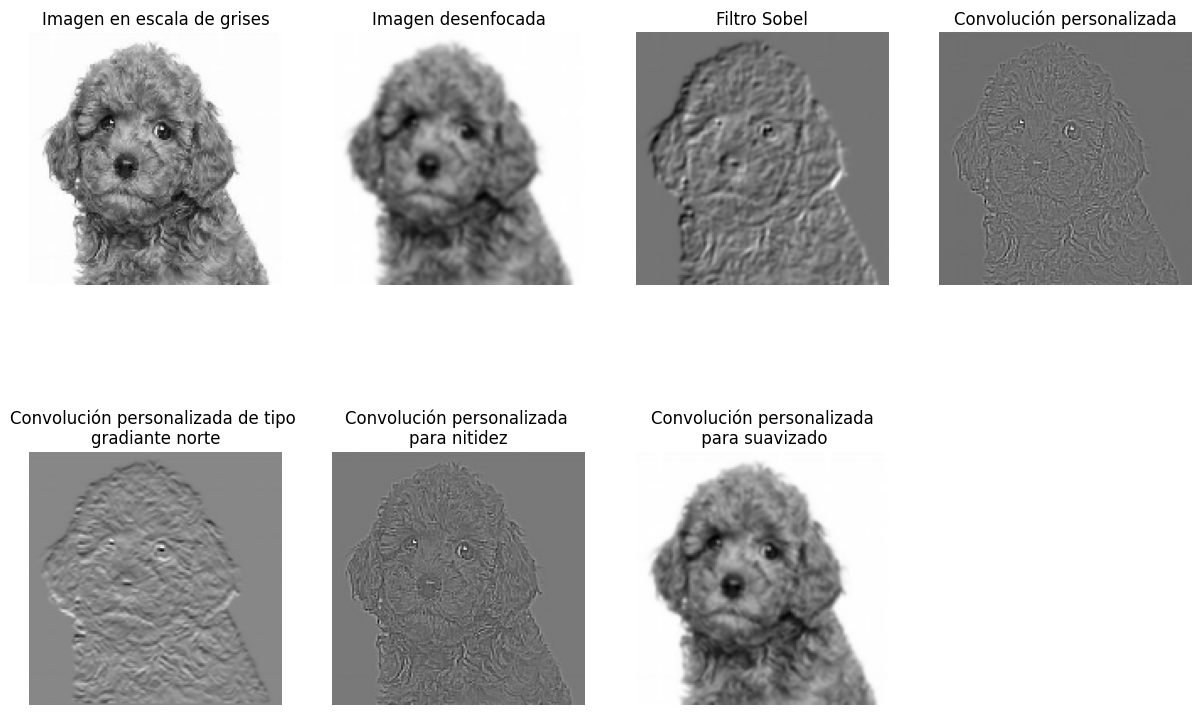

In [123]:
def apply_filters_and_convolutions(image):
    
    # Convertir la imagen a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Aplicar un filtro de desenfoque (blur)
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Aplicar un filtro de detección de bordes (Sobel)
    sobel_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=5)
    sobel_combined = cv2.addWeighted(sobel_x, 0.5, sobel_y, 0.5, 0)

    # Aplicar un filtro de convolución personalizado
    kernel = np.array([[-1, -1, -1],
                      [-1,  8, -1],
                      [-1, -1, -1]])
    custom_convolution = cv2.filter2D(gray_image, -1, kernel)

     # Aplicar un filtro de convolución personalizado de tipo gradainte norte
    kernel = np.array([[-1, -2, -1],
                      [0,  0, 0],
                      [1, 2, 1]])
    custom_convolution2 = cv2.filter2D(gray_image, -1, kernel)

     # Aplicar un filtro de convolución personalizado para nitidez de 3*3 sin escalado de grises
    kernel = np.array([[-1, -1, -1],
                      [-1,  9, -1],
                      [-1, -1, -1]])
    custom_convolution3 = cv2.filter2D(gray_image, -1, kernel)


      # Aplicar un filtro de convolución personalizado para suavizado de 3*3 sin escalado de grises
    kernel = np.array([[1, 2, 1],
                      [2, 4, 2],
                      [1, 2, 1]])
    custom_convolution4 = cv2.filter2D(gray_image, -1, kernel)
    return gray_image, blurred_image, sobel_combined, custom_convolution,custom_convolution2,custom_convolution3,custom_convolution4

def display_images(images, titles):
    plt.figure(figsize=(15, 10))
    for i in range(len(images)):
        plt.subplot(2, 4, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

images, _ = next(train_generator)

# Aplicar filtros y convoluciones a la primera imagen del batch
gray_image, blurred_image, sobel_combined, custom_convolution,custom_convolution2,custom_convolution3,custom_convolution4 = apply_filters_and_convolutions(images[0])

# Mostrar las imágenes resultantes
display_images([gray_image, blurred_image, sobel_combined, custom_convolution,custom_convolution2,custom_convolution3,custom_convolution4],
               ['Imagen en escala de grises', 'Imagen desenfocada', 'Filtro Sobel', 'Convolución personalizada','Convolución personalizada de tipo \ngradiante norte','Convolución personalizada \npara nitidez',
               'Convolución personalizada\n para suavizado'])

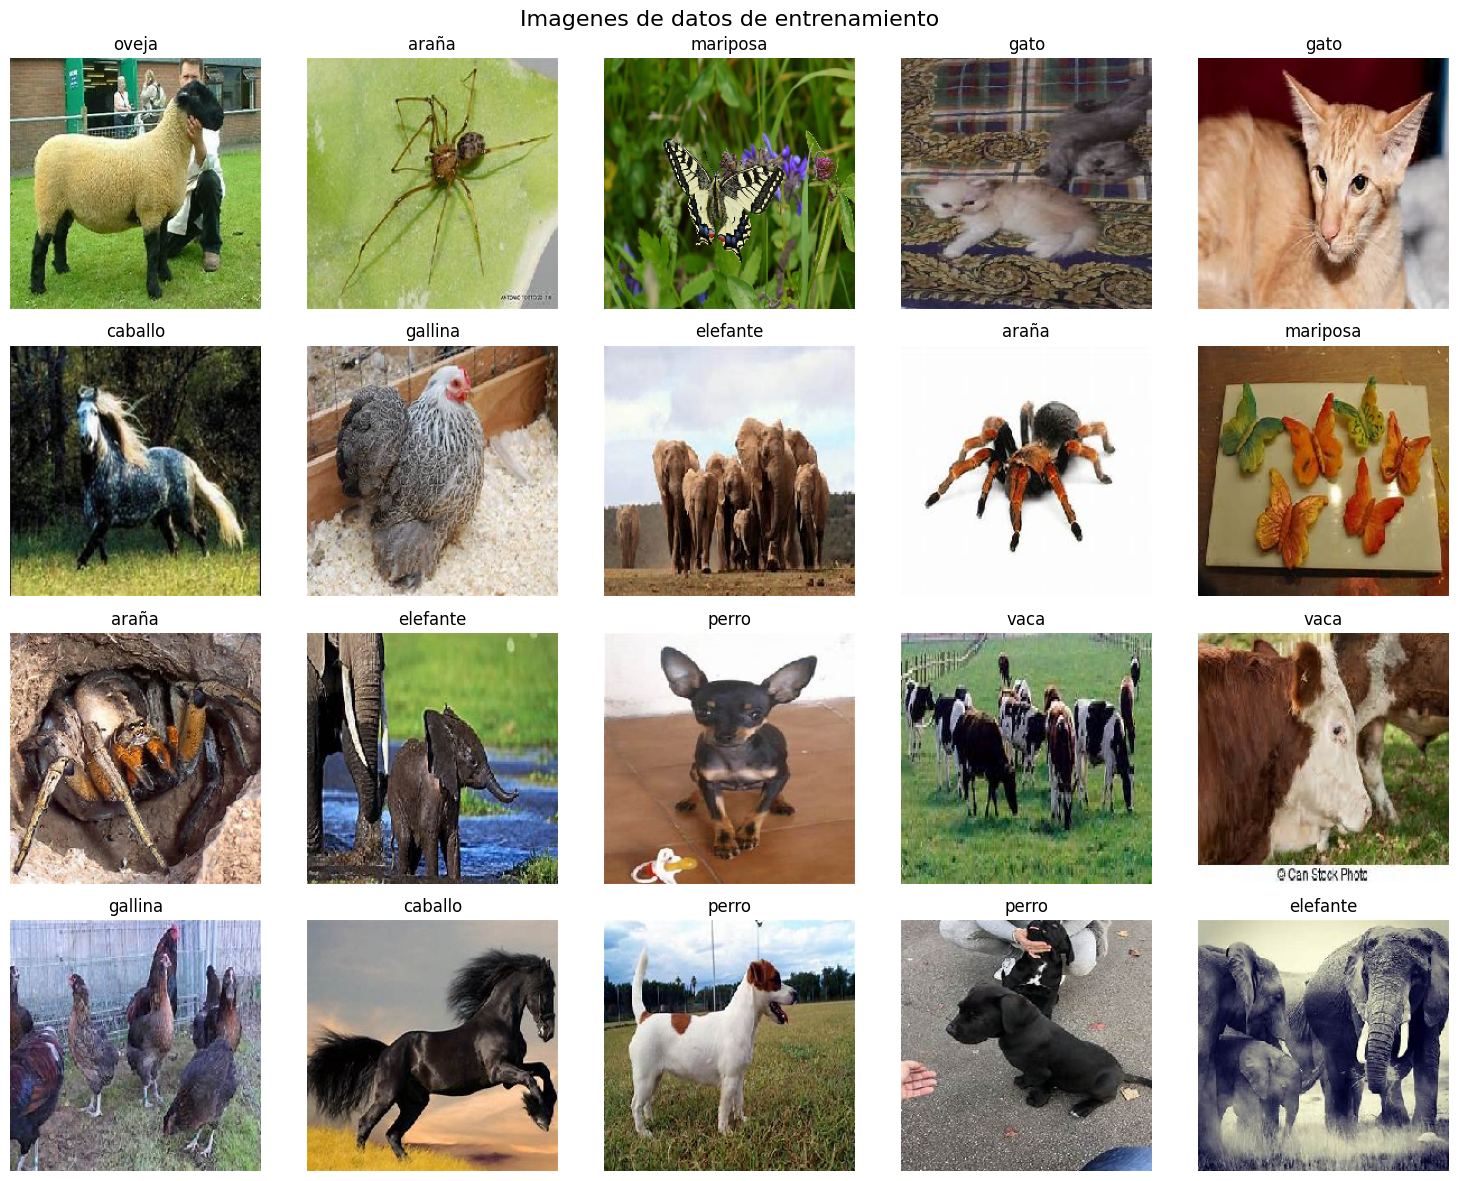

In [124]:
images, labels= next(train_data)


clases={v:k for k, v in train_data.class_indices.items()}#Obteniendo las classificaiones etiquetas de cada animal

label_nombres = [clases[np.argmax(label)] for label in labels]

fig, axes = plt.subplots(4, 5, figsize=(15, 12))
fig.suptitle("Imagenes de datos de entrenamiento", fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < len(images):
        ax.imshow(images[i])
        ax.set_title(label_nombres[i])
        ax.axis("off")

plt.tight_layout()
plt.show()

In [125]:
sequential_model = Sequential([
    Input(shape = (224, 224, 3)),
    
    Conv2D(16, 3, activation = "relu", padding = "same"),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(32, 3, activation = "relu", padding = "same"),
    MaxPooling2D(2, 2),
    Conv2D(64, 3, activation = "relu", padding = "same"),
    MaxPooling2D(2, 2),
    Conv2D(128, 3, activation = "relu", padding = "same"),
    MaxPooling2D(),

    tf.keras.layers.Flatten(),

    Dense(256, activation = "relu"),
    Dropout(0.2),
    Dense(512, activation = "relu"),
    Dropout(0.2),

    Dense(10, activation = "softmax")
])

sequential_model.compile(optimizer= "adam",
                         loss= "categorical_crossentropy",
                         metrics= ["accuracy"]) 


sequential_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 batch_normalization_21 (Bat  (None, 224, 224, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                     

In [126]:

history = sequential_model.fit(train_data,
                     epochs = 20, 
                     validation_data = test_data)

Epoch 1/20
819/819 [==============================] - 56s 68ms/step - loss: 1.7807 - accuracy: 0.3842 - val_loss: 1.3187 - val_accuracy: 0.5447
Epoch 2/20
819/819 [==============================] - 53s 65ms/step - loss: 1.2780 - accuracy: 0.5622 - val_loss: 0.9643 - val_accuracy: 0.6813
Epoch 3/20
819/819 [==============================] - 56s 69ms/step - loss: 1.0237 - accuracy: 0.6530 - val_loss: 0.8046 - val_accuracy: 0.7205
Epoch 4/20
819/819 [==============================] - 54s 66ms/step - loss: 0.8135 - accuracy: 0.7254 - val_loss: 0.6877 - val_accuracy: 0.7631
Epoch 5/20
819/819 [==============================] - 54s 65ms/step - loss: 0.6255 - accuracy: 0.7865 - val_loss: 0.3578 - val_accuracy: 0.8814
Epoch 6/20
819/819 [==============================] - 53s 65ms/step - loss: 0.4897 - accuracy: 0.8335 - val_loss: 0.2944 - val_accuracy: 0.9108
Epoch 7/20
819/819 [==============================] - 54s 66ms/step - loss: 0.4009 - accuracy: 0.8634 - val_loss: 0.2823 - val_accuracy:

In [127]:
test_loss, test_acc = sequential_model.evaluate(test_data)
print(f'\nPrecision en el conjunto de prueba: {test_acc:.4f}')

819/819 [==============================] - 27s 33ms/step - loss: 0.0369 - accuracy: 0.9905

Precision en el conjunto de prueba: 0.9905


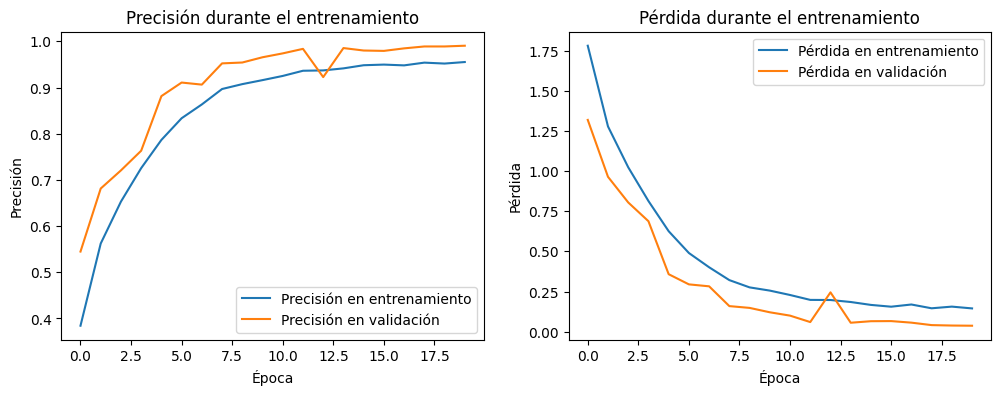

In [128]:
plt.figure(figsize=(12, 4)) ###grafica de precision durante entr
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2) ##graf perdida durante entrenamiento
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

819/819 [==============================] - 26s 32ms/step


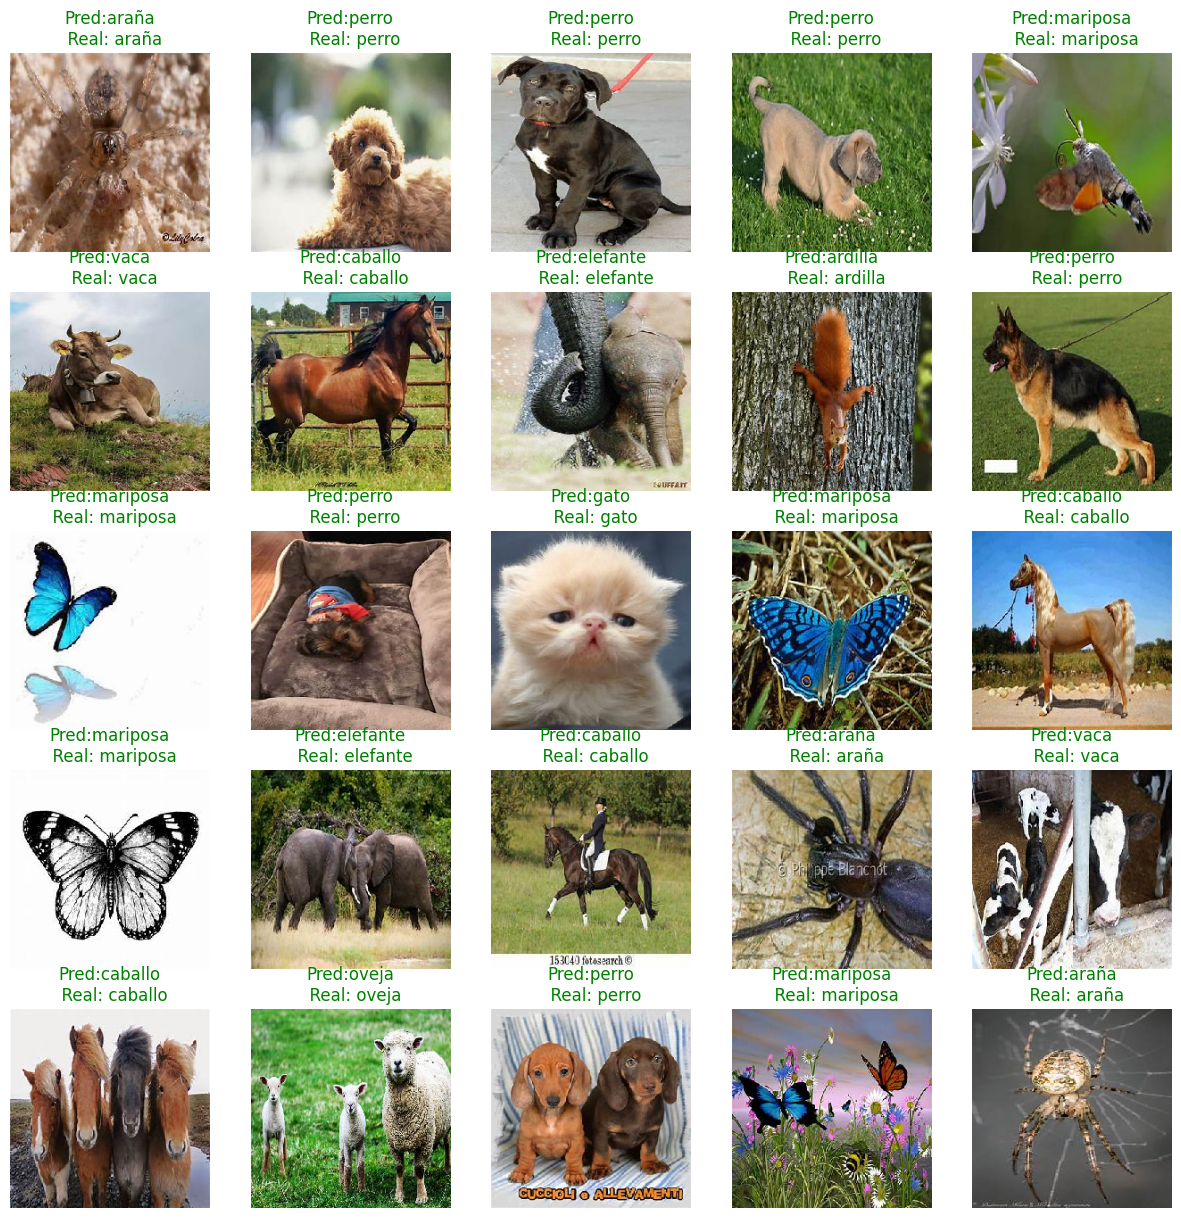

In [129]:
images, labels= next(test_data)
predictions = sequential_model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)



labelsP = (test_data.class_indices)
labelsP = dict((v,k) for k,v in labelsP.items())
predicted_labels = [labelsP[k] for k in predicted_labels]

clases={v:k for k, v in test_data.class_indices.items()}#Obteniendo las classificaiones etiquetas de cada animal

label_nombres = [clases[np.argmax(label)] for label in labels]




plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    color ='green' if predicted_labels[i] == label_nombres[i] else 'red'
    plt.title(f'Pred:{predicted_labels[i]}\n  Real: {label_nombres[i]}',color=color)
    plt.axis('off')
plt.show()

# Justificacion

Se utilizo una red neuronal convolucional (CNN) que emplea filtros convolucionales (Conv2D) como parte fundamental del proceso de extracción de caracteristicas, el uso de filtros de tamaño 3x3 con activacion ReLU, por su eficiencia y capacidad para capturar patrones locales como bordes, texturas y formas simples.
El filtro 3x3 examina pequeñas regiones de la imagen de entrada (3 píxeles por 3) para detectar caracteristicas visuales locales. Al combinar muchos de estos filtros con diferentes pesos, la red puede aprender a identificar patrones mas complejos conforme se avanza en profundidad, los filtros pequeños como el 3x3 requieren menos parametros, por lo cual acelera el entrenamiento.
En la red se utilizó una progresion de filtros: 16, 32, 64 y 128 el aumento progresivo permite a la red capturar caracteristicas simples en las primeras capas (bordes, contornos).